In [102]:
import numpy as np
import math
import operator
from scipy import ndimage
import matplotlib.pyplot as plt
import random

In [103]:
# union-rank by forest
class universe:
    def __init__(self, n_elements):
        self.num = n_elements
        self.elts = np.empty(shape=(n_elements, 3), dtype=int)
        for i in range(n_elements):
            self.elts[i, 0] = 0  # rank
            self.elts[i, 1] = 1  # size
            self.elts[i, 2] = i  # p

    def size(self, x):
        return self.elts[x, 1]

    def num_sets(self):
        return self.num

    def find(self, x):
        y = int(x)
        while y != self.elts[y, 2]:
            y = self.elts[y, 2]
        self.elts[x, 2] = y
        return y

    def join(self, x, y):
        if self.elts[x, 0] > self.elts[y, 0]:
            self.elts[y, 2] = x
            self.elts[x, 1] += self.elts[y, 1]
        else:
            self.elts[x, 2] = y
            self.elts[y, 1] += self.elts[x, 1]
            if self.elts[x, 0] == self.elts[y, 0]:
                self.elts[y, 0] += 1
        self.num -= 1

In [104]:
# segment graph
def segment_graph(edges,num_edges,num_vertices,thres):
    sorted(edges, key=lambda x: x[2])
    u = universe(num_vertices)
    thresholds = np.zeros(num_vertices)
    for i in range(num_vertices):
        thresholds[i] = get_threshold(1,thres)
    for i in range(num_edges):
        vi,vj,w =  edges[i]
        a = u.find(vi)
        b = u.find(vj)
        if a!=b:
            if w < thresholds[a] and w <thresholds[b]:
                u.join(a,b)
                a = u.find(a)
                thresholds[a] = w + get_threshold(u.size(a),thres)
    return u

def get_threshold(size,thres):
    return thres/size

def square(value):
    return value * value


def random_rgb():
    rgb = np.zeros(3, dtype=int)
    rgb[0] = random.randint(0, 255)
    rgb[1] = random.randint(0, 255)
    rgb[2] = random.randint(0, 255)
    return rgb


def diff(red_band, green_band, blue_band, x1, y1, x2, y2):
    result = math.sqrt(
        square(red_band[y1, x1] - red_band[y2, x2]) + square(green_band[y1, x1] - green_band[y2, x2]) + square(
            blue_band[y1, x1] - blue_band[y2, x2]))
    return result         
    
    
    

In [122]:

WIDTH = 4.0

def smooth(src, sigma):
    mask = make_fgauss(sigma)
    mask = normalize(mask)
    tmp = convolve_even(src, mask)
    dst = convolve_even(tmp, mask)
    return dst


def make_fgauss(sigma):
    sigma = max(sigma, 0.01)
    length = int(math.ceil(sigma * WIDTH)) + 1
    mask = np.zeros(shape=length, dtype=float)
    for i in range(length):
        mask[i] = math.exp(-0.5 * math.pow(i / sigma,2))
    return mask


def normalize(mask):
    sumx = 2 * np.sum(np.absolute(mask)) + abs(mask[0])
    return np.divide(mask, sumx)

def minimum(x,y):
    if x<y:
        return x
    else:
        return y

def convolve_even(src, mask):
    output = np.zeros(src.shape, dtype=float)
    height, width = src.shape
    length = len(mask)
    for y in range(height):
        for x in range(width):
            sumx = mask[0]*src[y, x]
            for i in  range(1,length):
                sumx = sumx + mask[i]*(src[y,max(x-i,0)] + src[y,minimum(x+i,width-1)])
            output[y, x] = sumx
    return output

/home/puneet/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


Loading is done.
processing...
6


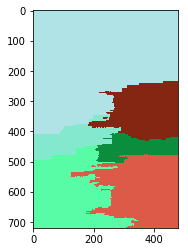

In [130]:
def segment(in_image, sigma, k, min_size):
    height, width, band = in_image.shape
    smooth_red_band = smooth(in_image[:, :, 0], sigma)
    smooth_green_band = smooth(in_image[:, :, 1], sigma)
    smooth_blue_band = smooth(in_image[:, :, 2], sigma)
    edges_size = width * height * 4
    edges = []
    num = 0
    for y in range(height):
        for x in range(width):
            if x < width - 1:
                edges.append((int(y * width + x) , int(y * width + (x + 1)) ,diff(smooth_red_band, smooth_green_band, smooth_blue_band, x, y, x + 1, y)))
                num += 1
            if y < height - 1:
                edges.append((int(y * width + x),int((y + 1) * width + x),diff(smooth_red_band, smooth_green_band, smooth_blue_band, x, y, x, y + 1)))
                num += 1
            if (x < width - 1) and (y < height - 2):
                edges.append((int(y * width + x),int((y + 1) * width + (x + 1)),diff(smooth_red_band, smooth_green_band, smooth_blue_band, x, y, x + 1, y + 1)))
                num += 1
            if (x < width - 1) and (y > 0):
                edges.append((int(y * width + x),int((y - 1) * width + (x + 1)),diff(smooth_red_band, smooth_green_band, smooth_blue_band, x, y, x + 1, y - 1)))
                num += 1
    u = segment_graph(edges,num,width * height, k)

    for i in range(num):
        vi,vj,w = edges[i]
        a = u.find(vi)
        b = u.find(vj)
        if (a != b) and ((u.size(a) < min_size) or (u.size(b) < min_size)):
            u.join(a, b)

    num_cc = u.num_sets()
    print(num_cc)
    output = np.zeros(shape=(height, width, 3))
    colors = np.zeros(shape=(height * width, 3))
    for i in range(height * width):
        colors[i, :] = random_rgb()

    for y in range(height):
        for x in range(width):
            comp = u.find(y * width + x)
            output[y, x, :] = colors[comp, :]
    plt.imshow(np.uint8(output))
    plt.show()


if __name__ == "__main__":
    input_path = "data/paris.jpg"
    input_image = ndimage.imread(input_path, flatten=False, mode=None)
    print("Loading is done.")
    print("processing...")
segment(input_image, 0.5, 300, 10000)